In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import joblib 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
import statsmodels.api as sm
from scipy import stats
import shap
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
## load data
trainfinal = pd.read_csv('train_data.csv')
testfinal = pd.read_csv('test.csv')

## labelencoding the target
label_encoder = preprocessing.LabelEncoder()
trainfinal['Factor'] = trainfinal['BiasInfluentialFactor']
trainfinal['BiasInfluentialFactor']= label_encoder.fit_transform(trainfinal['BiasInfluentialFactor'])
dict_bf = trainfinal[['BiasInfluentialFactor','Factor']].drop_duplicates()
dict_bf = dict(zip(dict_bf.BiasInfluentialFactor, dict_bf.Factor))
del trainfinal['Factor']

In [4]:
trainfinal.head()

,EmpID,LanguageOfCommunication,Gender,JobProfileIDApplyingFor,BiasInfluentialFactor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,CurrentCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,ExpectedRaise%,FitmentPercent
0,11041,English,Male,JR85289,9,B.Tech,Electrical,Tier 1,7,12,21,Married,5,SSE,Enterprise,Design,20,3.218876,0.9369
1,15079,English,Male,JR87525,8,B.Tech,Artificial Intelligence,Tier 3,7,3,15,Married,5,BA,MidSized,Engineering,6,3.332205,0.6709
2,18638,English,Female,JR87525,4,PhD,Computer Science,Tier 1,6,6,15,Single,5,SDE,MidSized,Engineering,19,4.110874,0.9126
3,3941,English,Female,JR87525,4,BCA,Information Technology,Tier 2,5,6,16,Married,5,SDE,Startup,Product,16,3.931826,0.7229
4,5936,English,Male,JR70175,1,Dual M.Tech,Computer Science,Tier 3,8,2,24,Married,5,SDE,Enterprise,Engineering,10,3.526361,0.8634


In [5]:
trainfinal.shape

(13645, 19)

### Categorical Encoding

In [6]:
cat_data = trainfinal.select_dtypes(exclude=[np.number])
cat_data.columns

Index(['LanguageOfCommunication', 'Gender', 'JobProfileIDApplyingFor',
       'HighestDegree', 'DegreeBranch', 'GraduatingInstitute', 'MartialStatus',
       'CurrentDesignation', 'CurrentCompanyType', 'DepartmentInCompany'],
      dtype='object')

In [7]:
categorical = ['LanguageOfCommunication', 'Gender', 'JobProfileIDApplyingFor', 
               'HighestDegree', 'DegreeBranch', 'GraduatingInstitute', 'MartialStatus', 
               'CurrentDesignation', 'CurrentCompanyType']

In [8]:
## create object of Binaryencoding
encoder = ce.BinaryEncoder(categorical)
enc = encoder.fit(trainfinal[categorical].values)
dfbin = enc.transform(trainfinal[categorical].values)
trainfinal = pd.concat([trainfinal, dfbin], axis = 1)
dfbin.columns = [enc.verbose[int(i.split('_')[0])]+"_"+i.split('_')[1] for i in dfbin.columns]

In [9]:
trainfinal.columns

Index(['EmpID', 'LanguageOfCommunication', 'Gender', 'JobProfileIDApplyingFor',
       'BiasInfluentialFactor', 'HighestDegree', 'DegreeBranch',
       'GraduatingInstitute', 'LatestDegreeCGPA', 'YearsOfExperince',
       'CurrentCTC', 'MartialStatus', 'EmpScore', 'CurrentDesignation',
       'CurrentCompanyType', 'DepartmentInCompany', 'TotalLeavesTaken',
       'ExpectedRaise%', 'FitmentPercent', '0_0', '0_1', '0_2', '1_0', '1_1',
       '1_2', '2_0', '2_1', '2_2', '2_3', '2_4', '3_0', '3_1', '3_2', '3_3',
       '4_0', '4_1', '4_2', '4_3', '5_0', '5_1', '5_2', '6_0', '6_1', '7_0',
       '7_1', '7_2', '7_3', '8_0', '8_1', '8_2'],
      dtype='object')

In [10]:
## VIF dataframe
vif_data = pd.DataFrame()
X = trainfinal[['YearsOfExperince', 'CurrentCTC', 'EmpScore', 
                '0_0', '0_1', '0_2', '1_0', '1_1', '1_2', '2_0',
                '2_1', '2_2', '2_3', '2_4', '3_0', '3_1', '3_2',
                '3_3', '4_0', '4_1', '4_2', '4_3', '5_0', '5_1',
                '5_2', '6_0', '6_1', '7_0', '7_1', '7_2', '7_3', 
                '8_0', '8_1', '8_2']].copy()

vif_data["feature"] = X.columns
  
## calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature        VIF
0   YearsOfExperince   1.001494
1         CurrentCTC   1.002105
2           EmpScore   1.000787
3                0_0        NaN
4                0_1   1.165210
5                0_2   1.164840
6                1_0        NaN
7                1_1   3.820564
8                1_2   3.821592
9                2_0        NaN
10               2_1   1.230971
11               2_2   1.080252
12               2_3   1.786356
13               2_4   1.730417
14               3_0   1.097349
15               3_1   1.348082
16               3_2   1.176953
17               3_3   1.561526
18               4_0        NaN
19               4_1   2.695695
20               4_2   2.236262
21               4_3   1.330798
22               5_0        NaN
23               5_1   1.161733
24               5_2   1.160803
25               6_0  30.965298
26               6_1  77.572921
27               7_0   1.089235
28               7_1   1.625150
29               7_2   1.412091
30      

In [11]:
numeric_features = ['YearsOfExperince', 'CurrentCTC', 'EmpScore', 'LatestDegreeCGPA']

In [12]:
## standardize the numeric features. 
scaler = StandardScaler()
scaler.fit(trainfinal[numeric_features])
scaled = scaler.transform(trainfinal[numeric_features])

for i, col in enumerate(numeric_features):
       trainfinal[col] = scaled[:,i]

### Train and Test Set split

In [13]:
X = trainfinal.drop(['EmpID', 'BiasInfluentialFactor', 'FitmentPercent', 'LanguageOfCommunication', 'Gender',
                     'JobProfileIDApplyingFor', 'DegreeBranch', 'MartialStatus', 'TotalLeavesTaken','GraduatingInstitute',
                     'CurrentDesignation', 'CurrentCompanyType', 'LatestDegreeCGPA', 'ExpectedRaise%', 'HighestDegree', 
                     'DepartmentInCompany', '0_0', '1_0', '2_0', '4_0', '5_0', '6_1', '8_0'], axis=1).copy()

Y = trainfinal['FitmentPercent'] 

X1 = trainfinal.drop(['EmpID', 'BiasInfluentialFactor', 'LanguageOfCommunication', 'Gender', 'JobProfileIDApplyingFor', 
                      'DegreeBranch', 'MartialStatus', 'TotalLeavesTaken', 'GraduatingInstitute', 'CurrentDesignation',
                      'CurrentCompanyType', 'ExpectedRaise%', 'DepartmentInCompany', 'HighestDegree',
                      '0_0', '1_0', '2_0', '4_0', '5_0', '6_1', '8_0'], axis=1).copy()

Y1 = trainfinal['BiasInfluentialFactor'] 

train, test, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state = 42)
train.shape, test.shape

((10916, 27), (2729, 27))

In [14]:
X1.columns

Index(['LatestDegreeCGPA', 'YearsOfExperince', 'CurrentCTC', 'EmpScore',
       'FitmentPercent', '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3',
       '2_4', '3_0', '3_1', '3_2', '3_3', '4_1', '4_2', '4_3', '5_1', '5_2',
       '6_0', '7_0', '7_1', '7_2', '7_3', '8_1', '8_2'],
      dtype='object')

In [15]:
## no of features
nof_list = np.arange(1,30)            
low_score = 1

## Variable to store the optimum features
nof = 0           
score_list =[]
for n in range(len(nof_list)):
    model = lgb.LGBMRegressor(silent=False)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(train,ytrain)
    X_test_rfe = rfe.transform(test)
    model.fit(X_train_rfe,ytrain)
    pred = model.predict(X_test_rfe)
    score = ((pred - ytest) ** 2).mean() ** .5
    score_list.append(score)
    if(score < low_score):
        low_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, low_score))

Optimum number of features: 23
Score with 23 features: 0.085995


In [16]:
## Transforming data using RFE
cols = train.columns
rfe = RFE(model, nof)

## Fitting the data to model
X_rfe = rfe.fit_transform(train, ytrain) 
model.fit(X_rfe, ytrain)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['YearsOfExperince', 'CurrentCTC', 'EmpScore', '0_1', '1_1', '1_2',
       '2_2', '2_3', '2_4', '3_1', '3_2', '3_3', '4_1', '4_2', '4_3', '5_1',
       '5_2', '6_0', '7_1', '7_2', '7_3', '8_1', '8_2'],
      dtype='object')


In [17]:
selected_features_rfe = ['YearsOfExperince', 'CurrentCTC', 'EmpScore',
                         '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3',
                         '2_4','3_0', '3_1', '3_2', '3_3', '4_1', '4_2',
                         '4_3', '5_1', '5_2', '6_0', '7_0', '7_1', '7_2',
                         '7_3', '8_1', '8_2']

train = train[selected_features_rfe]
test = test[selected_features_rfe]

### Model Training and Evaluation

In [18]:
pipelines = []
pipelines.append(('LR', Pipeline([('LR',LinearRegression())])))
pipelines.append(('LASSO', Pipeline([('LASSO', Lasso())])))
pipelines.append(('EN', Pipeline([('EN', ElasticNet())])))
pipelines.append(('KNN', Pipeline([('KNN', KNeighborsRegressor())])))
pipelines.append(('CART', Pipeline([('CART', DecisionTreeRegressor())])))
pipelines.append(('GBM', Pipeline([('GBM', GradientBoostingRegressor())])))
pipelines.append(('XGB', Pipeline([('XGB', xgb.XGBRegressor())])))
pipelines.append(('LGB', Pipeline([('LGB', lgb.LGBMRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = 10)
    cv_results = cross_val_score(model, train, ytrain, cv = kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.012869 (0.000715)
LASSO: -0.020506 (0.001214)
EN: -0.020506 (0.001214)
KNN: -0.014312 (0.000698)
CART: -0.014527 (0.000537)
GBM: -0.007605 (0.000344)
[18:41:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:41:39] WARNING: C:/

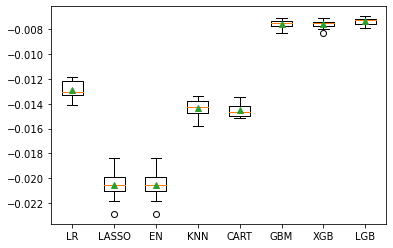

In [19]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [20]:
param_dist = {"max_depth": [15,20,25,30,40,50,75],
              "learning_rate" : [0.01,0.03,0.05,0.1],
              "num_leaves": [100,200,300,500,700,900,1200],
              "n_estimators": [400,500,600,800,900,1000],
              "max_bin": [80,90,100,120,150,180,200]
             }

#lg = lgb.LGBMRegressor(silent=False)
#grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv=3, scoring="neg_mean_squared_error", verbose=5)
#grid_search.fit(train, ytrain)
#grid_search.best_estimator_

In [21]:
def get_feature_importances(data, shuffle, seed=None):

    train_features = [f for f in data]
    y = ytrain
    if shuffle:
        y = ytrain.copy().sample(frac=1.0)

    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 20, 
    'learning_rate': 0.01,
    'num_leaves':200,    
    'verbose': 0,
    'n_estimators': 600,
    'max_bin': 80
    }
    
    model = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = model.feature_importance(importance_type='gain')
    imp_df["importance_split"] = model.feature_importance(importance_type='split')
    
    return imp_df, model

In [22]:
actual_imp_df, model = get_feature_importances(data=train, shuffle=False)

In [23]:
actual_imp_df.sort_values(by=['importance_gain'], ascending=False)

,feature,importance_gain,importance_split
6,1_2,2364.026316,1478
25,8_1,1929.193008,816
2,EmpScore,1720.050075,9363
1,CurrentCTC,1100.179903,23051
5,1_1,717.346500,2191
0,YearsOfExperince,286.011130,18336
12,3_1,80.539538,4919
3,0_1,78.752251,5159
10,2_4,76.173456,4829
17,4_3,74.098155,4434


No handles with labels found to put in legend.


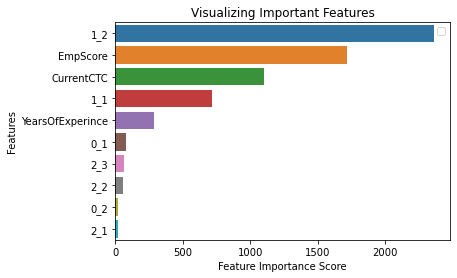

In [24]:
## Creating a bar plot
feature_imp=actual_imp_df.head(10).sort_values(by='importance_gain')
feature_imp=actual_imp_df.reset_index()[['feature', 'importance_gain']].head(10)
sns.barplot(y=feature_imp.feature,x=feature_imp.importance_gain,order=feature_imp.sort_values('importance_gain', ascending=False).feature)

## Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [25]:
pred = model.predict(test)
ytest = ytest.reset_index(drop=True)

In [26]:
coefficient_of_dermination = r2_score(pred, ytest)
print('r2 score:', coefficient_of_dermination)

r2 score: 0.437237011682828


In [27]:
a = (1 - coefficient_of_dermination) * (len(ytest) - 1)
b = len(ytest) - train.shape[1]  - 1
print('Adjusted r2 score:', 1 - a /b)

Adjusted r2 score: 0.43161146533534056


In [28]:
rmse = ((pred - ytest) ** 2).mean() ** .5
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.08806507842469764


In [29]:
## Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

## Calculate Shap values
shap_values = explainer.shap_values(test)

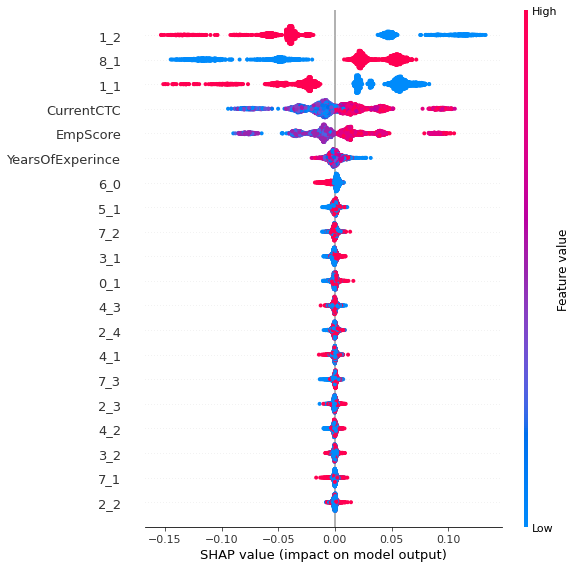

In [30]:
shap.summary_plot(shap_values, test)

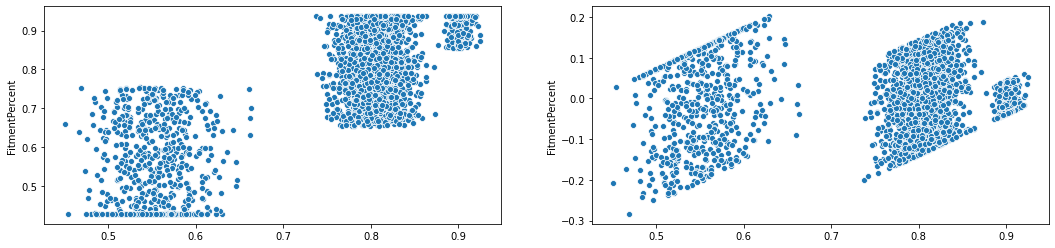

In [31]:
## residual plot
error = pred - ytest
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 4))
sns.scatterplot(pred, ytest, ax=ax[0])
sns.scatterplot(pred, error,  ax=ax[1])

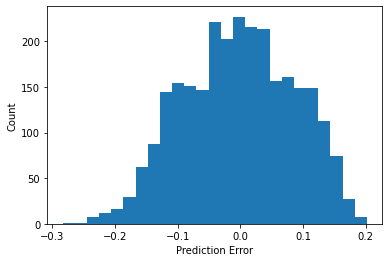

In [32]:
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [33]:
out = pd.DataFrame()
out['pred'] = pred
out['actual'] = ytest
out['actualprob'] = pd.cut(out['actual'], 10)
df = out[['actualprob','pred']].groupby(['actualprob']).agg(['min', 'mean', 'max']).reset_index()
df

actualprob      pred                    
                        min      mean       max
0  (0.427, 0.479]  0.454581  0.550855  0.629450
1  (0.479, 0.529]  0.477544  0.559810  0.647611
2   (0.529, 0.58]  0.473234  0.553902  0.646040
3   (0.58, 0.631]  0.475466  0.559463  0.662041
4  (0.631, 0.682]  0.450546  0.703407  0.858717
5  (0.682, 0.733]  0.481769  0.751288  0.873679
6  (0.733, 0.784]  0.469347  0.780281  0.862901
7  (0.784, 0.835]  0.738072  0.806674  0.871609
8  (0.835, 0.886]  0.746343  0.826642  0.924578
9  (0.886, 0.937]  0.737083  0.842326  0.924020

In [34]:
X1.to_csv('X1.csv', index=False)
Y1.to_csv('Y1.csv', index=False)
joblib.dump(dict_bf, 'dictfactor')
joblib.dump(enc, 'enc.pkl')
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [35]:
## Gaussian Mixture (Gmm).(Try)
## The basics of the following process are:
##  * Split the data into 2 based on the Gmm distribution output.
##  * Train a classification model to predict which distribution it belongs to.
##  * Train 2 regression models on each of the distributions.

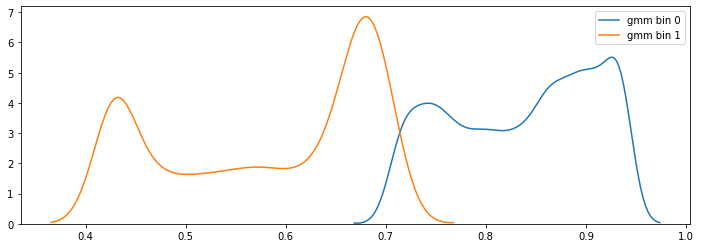

In [36]:
## apply gaussian mix / assign bins back to training
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(trainfinal['FitmentPercent'].values.reshape(-1, 1))
trainfinal['target_gmm'] = gmm.predict(trainfinal['FitmentPercent'].values.reshape(-1, 1))

## masks for each gmm bin
mask_gmm_0 = trainfinal['target_gmm'] == 0
mask_gmm_1 = trainfinal['target_gmm'] == 1

## plot
fig, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=trainfinal.loc[mask_gmm_0, 'FitmentPercent'], label='gmm bin 0')
sns.kdeplot(data=trainfinal.loc[mask_gmm_1, 'FitmentPercent'], label='gmm bin 1')
plt.show()

In [37]:
## split training data / reset indexes
Y = trainfinal['target_gmm']

train, test, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state = 42)
train.shape, test.shape

((10916, 27), (2729, 27))

In [38]:
clf = lgb.LGBMClassifier(objective = 'binary',
        max_bin = 120,
        num_leaves = 200,
        max_depth = 40,
        bagging_freq = 1,
        n_jobs = 4,
        learning_rate = 0.01,
        classweight = 'balanced',
        n_estimators =  600)
clf.fit(train,ytrain)

LGBMClassifier(bagging_freq=1, classweight='balanced', learning_rate=0.01,
               max_bin=120, max_depth=40, n_estimators=600, n_jobs=4,
               num_leaves=200, objective='binary')

In [39]:
ypred = clf.predict(test)

In [40]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1931
           1       0.86      0.66      0.75       798

    accuracy                           0.87      2729
   macro avg       0.87      0.81      0.83      2729
weighted avg       0.87      0.87      0.86      2729



In [41]:
lgbm_gmm_reg_0 = lgb.LGBMRegressor(boosting_type = 'gbdt',
                 objective = 'regression',
                 metric = 'rmse',
                 max_depth = 20, 
                 learning_rate = 0.01,
                 num_leaves = 200,    
                 verbose = 0,
                 n_estimators = 600,
                 max_bin = 90)

In [42]:
X0 = trainfinal[trainfinal['target_gmm'] == 0][selected_features_rfe]
Y0 = trainfinal[trainfinal['target_gmm'] == 0]['FitmentPercent']

train, test, ytrain, ytest = train_test_split(X0, Y0, test_size = 0.2, random_state = 42)
train.shape, test.shape

((7661, 27), (1916, 27))

In [43]:
lgbm_gmm_reg_0.fit(train,ytrain)
pred0 = lgbm_gmm_reg_0.predict(test)

In [44]:
coefficient_of_dermination = r2_score(pred0, ytest)
print('r2 score:', coefficient_of_dermination)

r2 score: -1.5873270034489968


In [45]:
rmse = ((pred0 - ytest) ** 2).mean() ** .5
print(rmse)

0.06584330483490304


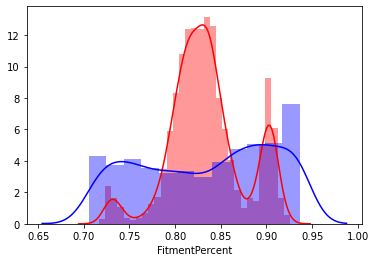

In [46]:
sns.distplot(pred0, color = 'red')
sns.distplot(ytest, color = 'blue')

In [47]:
out = pd.DataFrame()
out['pred'] = pred0
out['ytest'] = ytest
out['actualprob'] = pd.cut(out['ytest'], 10)
df = out[['actualprob','pred']].groupby(['actualprob']).agg(['min', 'mean', 'max']).reset_index()
df

actualprob      pred                    
                        min      mean       max
0  (0.706, 0.729]  0.728923  0.830876  0.900835
1  (0.729, 0.752]  0.728646  0.831855  0.903999
2  (0.752, 0.775]  0.763964  0.856102  0.910193
3  (0.775, 0.798]  0.727894  0.827878  0.907451
4  (0.798, 0.821]  0.783098  0.830633  0.908815
5  (0.821, 0.844]  0.725370  0.821962  0.913897
6  (0.844, 0.868]  0.784531  0.840380  0.900432
7  (0.868, 0.891]  0.736898  0.812032  0.863383
8  (0.891, 0.914]  0.784584  0.831788  0.910729
9  (0.914, 0.937]  0.725602  0.816980  0.905374

In [48]:
lgbm_gmm_reg_1 = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=400,
              subsample=0.6)

In [49]:
X1 = trainfinal[trainfinal['target_gmm'] == 1][selected_features_rfe]
Y1 = trainfinal[trainfinal['target_gmm'] == 1]['FitmentPercent']

train, test, ytrain, ytest = train_test_split(X1, Y1, test_size = 0.2, random_state = 42)
train.shape, test.shape

((3254, 27), (814, 27))

In [50]:
lgbm_gmm_reg_1.fit(train,ytrain)
pred1 = lgbm_gmm_reg_1.predict(test)

In [51]:
coefficient_of_dermination = r2_score(pred1, ytest)
print('r2 score:', coefficient_of_dermination)

r2 score: -0.2386557683507997


In [52]:
rmse = ((pred1 - ytest) ** 2).mean() ** .5
print(rmse)

0.07718465129674923


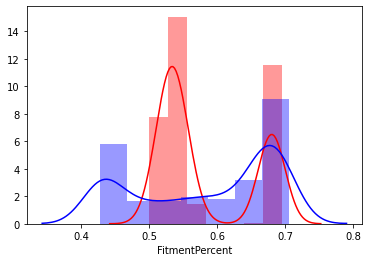

In [53]:
sns.distplot(pred1, color = 'red')
sns.distplot(ytest, color = 'blue')

In [54]:
out = pd.DataFrame()
out['pred'] = pred1
out['ytest'] = ytest
out['actualprob'] = pd.cut(out['ytest'], 10)
df = out[['actualprob','pred']].groupby(['actualprob']).agg(['min', 'mean', 'max']).reset_index()
df

actualprob      pred                    
                        min      mean       max
0  (0.427, 0.455]  0.515542  0.558520  0.680789
1  (0.455, 0.483]  0.521361  0.527666  0.533430
2   (0.483, 0.51]  0.513816  0.597507  0.678627
3   (0.51, 0.538]  0.505476  0.520317  0.535159
4  (0.538, 0.566]  0.522794  0.522794  0.522794
5  (0.566, 0.593]  0.519974  0.591367  0.684376
6  (0.593, 0.621]  0.533859  0.545832  0.557805
7  (0.621, 0.648]  0.518675  0.596584  0.684577
8  (0.648, 0.676]  0.519209  0.591600  0.686129
9  (0.676, 0.704]  0.507348  0.575559  0.684003

In [55]:
dfbin = enc.transform(testfinal[categorical].values)
testfinal = pd.concat([testfinal, dfbin], axis = 1)

In [56]:
X = testfinal[['YearsOfExperince', 'CurrentCTC', 'EmpScore',
              '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3',
               '2_4', '3_0', '3_1', '3_2', '3_3', '4_1', '4_2',
               '4_3', '5_1', '5_2', '6_0', '7_0', '7_1', '7_2',
               '7_3', '8_1', '8_2']]

X['lbl'] = clf.predict(X)

In [57]:
X11 = X[X['lbl'] == 0][selected_features_rfe]
X12 = X[X['lbl'] == 1][selected_features_rfe]

In [58]:
X11['pred'] = lgbm_gmm_reg_0.predict(X11)
X12['pred'] = lgbm_gmm_reg_1.predict(X12)

In [59]:
final = X11.append(X12)
testfinal['FitmentPercent'] = final['pred'] 
testfinal.to_csv('gmm.csv', index=False)

In [60]:
## Making a prediction using the classifier and the 2 Gmm regressors gives similar prediction